In [84]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
import os
import re
import numpy as np
import seaborn
import tensorflow as tf
import datetime
import time
from shutil import copyfile
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM
from collections import Counter
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score

%matplotlib inline 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def projection_on_set(vector, set_of_vectors):
    projection_vector = np.zeros(*vector.shape) 
    for ort_vector in set_of_vectors:
        projection_vector += np.dot(vector, ort_vector) / np.linalg.norm(ort_vector) * ort_vector
    return projection_vector

In [7]:
import AnonymousWalkEmbeddings, AnonymousWalkKernel, func_tools

In [8]:
reload(AnonymousWalkEmbeddings)

<module 'AnonymousWalkEmbeddings' from 'AnonymousWalkEmbeddings.pyc'>

In [9]:
reload(AnonymousWalkKernel)

<module 'AnonymousWalkKernel' from 'AnonymousWalkKernel.pyc'>

# Детектирование аномалий в потоках графов 

## Описание 

В этом блоке будем сравнивать алгоритмы, которые могут выделять аномальные элементы в потоках графов.
Для сравнения будем использовать алгоритмы [ParCube](#parcube), [DeltaCon](#deltacon), [Concept Drift and Anomaly Detection in Graph Streams](#cdadgs) и [наш](#ref) алгоритм

Будем проводить эксперименты на датасете [TwitterSecurity2014](http://odds.cs.stonybrook.edu/twittersecurity-dataset/)
* количество нод ~ 130 к
* количество таймстемпов ~ 120 
* 20 аномальных дней 

Сам датасет состоит из строк вида: user_1 user_2 number_of_co-mentions

В качестве метрики для сравнения будем считать precision/recall 


<a id='parcube'></a>

## ParCube

<a id='deltacon'></a>

## DeltaCon

<a id='cdadgs'>

## Concept Drift and Anomaly Detection in Graph Streams

<a id='ref'></a>

## Reference 

Сначала пробмуем поучить модель с такими же параметрами, как на MUTAG из туториала

In [10]:
dataset = ''

batch_size = 200
window_size = 2
num_samples = 256

root = '../DD/'
ext = 'graphml'
epochs = 3
batches_per_epoch = 200
candidate_func = 'uniform'
graph_labels = None

model = AnonymousWalkEmbeddings.AWE(dataset = dataset, batch_size = batch_size, window_size = window_size,
                  num_samples = num_samples, root = root,
                  ext = ext, epochs = epochs, batches_per_epoch = batches_per_epoch,
                  candidate_func = candidate_func, graph_labels=graph_labels)

model.train()

Number of graphs: 600
Number of words: 203
Initialized
Epoch: 0
Graph 0: 37 nodes
Average loss at step 100: 6583.571959
Average loss at step 200: 1092.649179
Average loss at step 300: 608.776665
Average loss at step 400: 512.629523
Average loss at step 500: 475.712387
Average loss at step 600: 465.809455
Average loss at step 700: 452.367608
Average loss at step 800: 449.253075
Average loss at step 900: 440.461396
Average loss at step 1000: 436.225709
Time: 57.7240409851
Graph 1: 23 nodes
Average loss at step 1100: 775.175831
Average loss at step 1200: 469.608985
Average loss at step 1300: 461.144233
Average loss at step 1400: 459.399336
Average loss at step 1500: 454.750434
Average loss at step 1600: 445.991252
Average loss at step 1700: 449.588799
Average loss at step 1800: 449.613976
Average loss at step 1900: 448.775502
Average loss at step 2000: 442.475475
Graph 2: 25 nodes
Average loss at step 2100: 706.207592
Average loss at step 2200: 477.423511
Average loss at step 2300: 470.97

In [ ]:
dataset = ''

batch_size = 10
window_size = 4
num_samples = 128

root = '../NCI1/'
ext = 'graphml'
epochs = 1
batches_per_epoch = 5000
candidate_func = 'uniform'
graph_labels = 'edges'

model1 = AnonymousWalkEmbeddings.AWE(dataset = dataset, batch_size = batch_size, window_size = window_size,
                  num_samples = num_samples, root = root,
                  ext = ext,epochs = epochs, batches_per_epoch = batches_per_epoch,
                  candidate_func = candidate_func, graph_labels=graph_labels)

model1.train()

Number of graphs: 4127
Number of words: 203
Initialized
Epoch: 0
Graph 0: 19 nodes
Average loss at step 100: 7307.982849
Average loss at step 200: 1942.744523
Average loss at step 300: 769.240798
Average loss at step 400: 509.437876
Average loss at step 500: 425.491517
Average loss at step 600: 398.636527
Average loss at step 700: 375.318670
Average loss at step 800: 372.443504
Average loss at step 900: 363.731722
Average loss at step 1000: 362.946617
Average loss at step 1100: 352.959707
Average loss at step 1200: 352.658599
Average loss at step 1300: 348.796355
Average loss at step 1400: 344.631526
Average loss at step 1500: 348.651993
Average loss at step 1600: 343.474630
Average loss at step 1700: 342.307970
Average loss at step 1800: 344.178941
Average loss at step 1900: 340.985013
Average loss at step 2000: 339.017730
Average loss at step 2100: 344.622488
Average loss at step 2200: 345.871047
Average loss at step 2300: 339.205139
Average loss at step 2400: 341.376259
Average loss

# Подгрузим разметку для графов 

In [69]:
labels = open('../NCI109/NCI109_label.txt')
labels = labels.read()
labels = np.array(map(lambda x: int(x), labels.strip().split()))

In [260]:
labels1 = open('../enron/parsed_graphs/labels.txt')
labels1 = labels1.read()
labels1 = np.array(map(lambda x: int(x), labels1.strip().split()))

### PCA approximation
Здесь пробуем построить для части графов pca и потом посчитать проекции следующих эмбедингов на полученные направления. Нас интересует, как хорошо полученные проекции могут аппроксимировать сами эмбединги.

Видим, что аутлаеры не особо выбиваются из общего паттерна. Дальше попробуем посмотреть, чем можно такое поведение объяснить. 

/Users/Macbook/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/Macbook/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


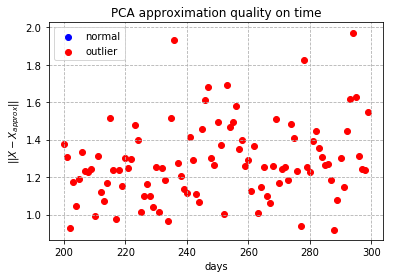

In [12]:
pca_comp_number = 100

test_set = model.graph_embeddings[:pca_comp_number]

pca = PCA(n_components=10)
pca.fit(scale(test_set))

projection_set = pca.components_[:]

res = []
for embedding in model.graph_embeddings[pca_comp_number:]:
    proj = projection_on_set(embedding, projection_set)
    res.append(np.linalg.norm(embedding - proj))
res = np.array(res)

fig = plt.figure()
plt.scatter(np.where(labels[pca_comp_number:] == 0)[0]+pca_comp_number, 
            res[np.where(labels[pca_comp_number:] == 0)[0]], label='normal', c='b')
plt.scatter(np.where(labels[pca_comp_number:] == 1)[0]+pca_comp_number, 
            res[np.where(labels[pca_comp_number:] == 1)[0]], label='outlier', c='r')
plt.xlabel("days")
plt.ylabel("$||X - X_{approx}||$")
plt.title("PCA approximation quality on time")
plt.legend()
plt.grid(ls='dashed')
#fig.savefig('graph_series_without_norm.pdf', format='pdf')

### Norm differences 

Посмотрим, как меняются векторы эмбедингов от времени. Для этого, например, можно порисовать норму разностей двух последующих векторов. Как видно из графиков какой-то хорошей шшеометрической структуры пока не получили.

KeyboardInterrupt: 

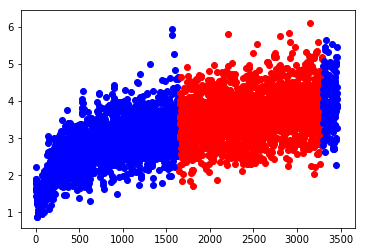

In [443]:
fig = plt.figure()
for i, label in zip(range(len(labels[:-1])), labels[:-1]):
    if label == 0:
        plt.scatter(i, np.linalg.norm(model.graph_embeddings[i+1] - model.graph_embeddings[i]), c='b')
    else:
        plt.scatter(i, np.linalg.norm(model.graph_embeddings[i+1] - model.graph_embeddings[i]), c='r')
    
plt.xlabel('days')
plt.ylabel('$||X_{i+1} - X_{i}||$')
plt.title("Norm of embedding differences on time")
plt.grid(alpha=0.6)
#fig.savefig('difference_embedding.pdf', format='pdf')

### Norm series 

Есть предположение о том, что аутлаеры сильно будут отличаться по норме от обычных векторов. Построим график зависимости норм векторов от времени. Получаем, что мало того, что аутлаеры не выбиваются из общей кучи, так еще необычное поведение с ростом нормы эмбедингов. Дальше попробуем разобраться, чем оно вызвано.

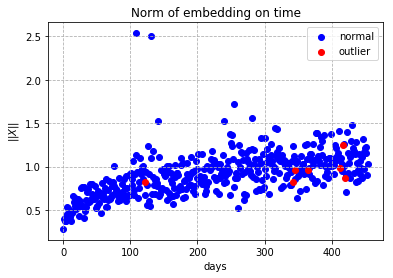

In [394]:
fig = plt.figure()
norms = np.linalg.norm(model.graph_embeddings, axis=1)

plt.scatter(np.where(labels == 0)[0], norms[np.where(labels == 0)[0]], label='normal', c='b')
plt.scatter(np.where(labels == 1)[0], norms[np.where(labels == 1)[0]], label='outlier', c='r')

plt.xlabel("days")
plt.ylabel("$||X||$")
plt.title("Norm of embedding on time")

plt.legend()
plt.grid(ls='dashed')
#fig.savefig('norms_series.pdf', format='pdf')

### Norm growth

Попробуем более отдельно рассмотреть вопрос с прошлого пункта. Интерсно, чем конкретно вызвано такое поведение у эмбедингов: либо это специфика модели, либо датасета. 

Чтобы проверить это предположение попробуем случайно помешать первые графы при обучении и снова отрисовать графики зависимости нормы от времени.

Получаем, что на самом деле такой вид графика не зависит от датасета, а относится к самой модели. Плюс к этому, вид графика завист от парметра batches_per_epoch. Чем он больше, тем более гладким получается график. При совсем мелких значениях такая зависимость нормы от времени пропадает. 

In [180]:
dataset = 'parsed_graphs'

batch_size = 100
window_size = 10
embedding_size_w = 64
embedding_size_d = 2
num_samples = 32

concat = False
loss_type = 'sampled_softmax'
optimize = 'Adagrad'
learning_rate = 1.0
root = '../enron/'
ext = 'graphml'
steps = 5
epochs = 2
batches_per_epoch = 10
candidate_func = None
graph_labels = None

model2 = AnonymousWalkEmbeddings.AWE(dataset = dataset, batch_size = batch_size, window_size = window_size,
                  embedding_size_w = embedding_size_w, embedding_size_d = embedding_size_d,
                  num_samples = num_samples, concat = concat, loss_type = loss_type,
                  optimize = optimize, learning_rate = learning_rate, root = root,
                  ext = ext, steps = steps, epochs = epochs, batches_per_epoch = batches_per_epoch,
                  candidate_func = candidate_func, graph_labels=graph_labels)

model2.train()

Number of graphs: 637
Number of words: 52
Initialized
Epoch: 0
Graph 0: 20 nodes
Time: 0.71936416626
Graph 1: 277 nodes
Graph 2: 274 nodes
Graph 3: 278 nodes
Graph 4: 293 nodes
Graph 5: 262 nodes
Graph 6: 9 nodes
Graph 7: 8 nodes
Graph 8: 31 nodes
Graph 9: 32 nodes
Average loss at step 100: 2627.964609
Graph 10: 264 nodes
Time: 0.589840173721
Graph 11: 229 nodes
Graph 12: 230 nodes
Graph 13: 18 nodes
Graph 14: 24 nodes
Graph 15: 306 nodes
Graph 16: 262 nodes
Graph 17: 229 nodes
Graph 18: 277 nodes
Graph 19: 200 nodes
Average loss at step 200: 606.774198
Graph 20: 16 nodes
Time: 0.440363883972
Graph 21: 12 nodes
Graph 22: 232 nodes
Graph 23: 245 nodes
Graph 24: 252 nodes
Graph 25: 207 nodes
Graph 26: 207 nodes
Graph 27: 8 nodes
Graph 28: 50 nodes
Graph 29: 249 nodes
Average loss at step 300: 235.295613
Graph 30: 263 nodes
Time: 0.569179058075
Graph 31: 237 nodes
Graph 32: 248 nodes
Graph 33: 250 nodes
Graph 34: 13 nodes
Graph 35: 45 nodes
Graph 36: 333 nodes
Graph 37: 266 nodes
Graph 38

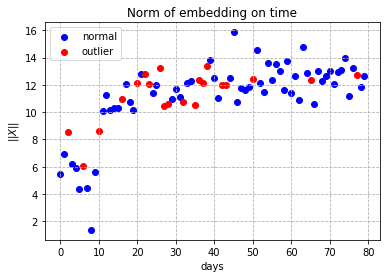

In [29]:
shuffles = ['timestep_3.graphml', 'timestep_7.graphml', 'timestep_9.graphml',
            'timestep_4.graphml', 'timestep_8.graphml', 'timestep_1.graphml', 
            'timestep_5.graphml', 'timestep_2.graphml', 'timestep_0.graphml', 
            'timestep_6.graphml']

shuffles = map(lambda x: int(x[:-8].split('_')[1]), shuffles)

fig = plt.figure()
right_order_ge = np.concatenate((model2.graph_embeddings[shuffles], model2.graph_embeddings[10:]))
norms = np.linalg.norm(right_order_ge, axis=1)

plt.scatter(np.where(labels == 0)[0], norms[np.where(labels == 0)[0]], label='normal', c='b')
plt.scatter(np.where(labels == 1)[0], norms[np.where(labels == 1)[0]], label='outlier', c='r')

plt.xlabel("days")
plt.ylabel("$||X||$")
plt.title("Norm of embedding on time")

plt.legend()
plt.grid(ls='dashed')
#fig.savefig('norms_series_shuffled.pdf', format='pdf')

### Matrix norm 


Посмотрим, что происходит с нормой матрицы слов. 

### Embeddings characteristics 

### One class SVM 

Попробуем поискать выбросы, не учитывая то, что в задаче имеется временная зависимость. Тут пробуем одноклассовый svm, в следующем пункте пробуем isolation forest

In [395]:
from sklearn.svm import OneClassSVM

In [396]:
np.where(labels == 1)

(array([122, 343, 345, 365, 412, 417, 420]),)

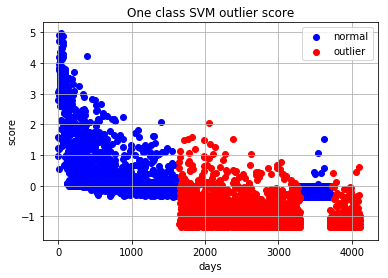

In [445]:
start, stop = 1, 5000
fig = plt.figure()
cls = OneClassSVM(kernel='rbf', gamma=0.9)
cls.fit(model.graph_embeddings[np.where(labels == 0)[0]][start:stop])
plt.scatter(np.where(labels==0), 
            cls.decision_function(model.graph_embeddings)[np.where(labels==0)], c='b', label='normal')
plt.scatter(np.where(labels==1), 
            cls.decision_function(model.graph_embeddings)[np.where(labels==1)], c='r', label='outlier')
plt.grid()
plt.title("One class SVM outlier score")
plt.ylabel('score')
plt.xlabel('days')
plt.legend()
fig.savefig('oneclass_svm.pdf', format='pdf')  

### Isolation forest

In [411]:
from sklearn.ensemble import IsolationForest

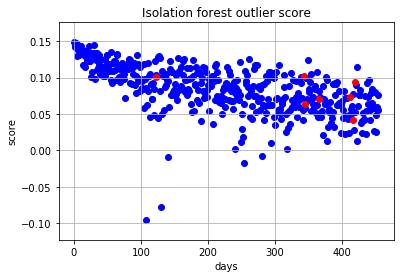

In [412]:
fig = plt.figure()
cls = IsolationForest(n_estimators=200)
cls.fit(model.graph_embeddings[np.where(labels == 0)[0]][:])
plt.scatter(np.where(labels==0), 
            cls.decision_function(model.graph_embeddings)[np.where(labels==0)], c='b', label='normal')
plt.scatter(np.where(labels==1), 
            cls.decision_function(model.graph_embeddings)[np.where(labels==1)], c='r', label='outlier')

plt.title("Isolation forest outlier score")
plt.ylabel('score')
plt.xlabel('days')
plt.grid()
fig.savefig('isolation_forest.pdf', format='pdf')

In [449]:
1.0 * sum(labels) / len(labels)

0.5004866180048662

# Всякие разные вопросы, возникшие по ходу 

* можно ли считать AUC для такой задачи, чтобы сравнивать модели?

In [215]:
from sklearn.manifold import TSNE

In [446]:
tsne = TSNE(perplexity=40)
start = 50
X = tsne.fit_transform(model.graph_embeddings[start:])

plt.scatter(X[np.where(labels[start:] == 0)[0], 0], X[np.where(labels[start:] == 0)[0], 1], label='normal', c='b')
plt.scatter(X[np.where(labels[start:] == 1)[0], 0], X[np.where(labels[start:] == 1)[0], 1], label='outlier', c='r')
plt.title("TSNE on embeddings")
plt.legend()
plt.grid(alpha=0.7)
#plt.scatter(norms[np.where(labels == 1)[0]], label='outlier', c='r')

KeyboardInterrupt: 

In [258]:
%matplotlib notebook

KeyboardInterrupt: 

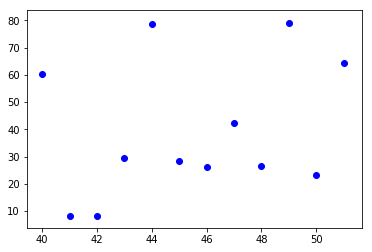

In [220]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

prev_cnt = 40
for i, label in zip(range(prev_cnt, len(labels[prev_cnt:])), labels[prev_cnt:]):
    vector_weight = 1 / np.exp(range(0, prev_cnt))
    if label == 0:
        ax.scatter(i, np.linalg.norm(model.graph_embeddings[i] - sum(model.graph_embeddings[i-prev_cnt:i].T.dot(vector_weight))), c='b')
    else:
        ax.scatter(i, np.linalg.norm(model.graph_embeddings[i] - sum(model.graph_embeddings[i-prev_cnt:i].T.dot(vector_weight))), c='r')
    fig.canvas.draw()   
    time.sleep(0.5)

/Users/Macbook/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


KeyboardInterrupt: 

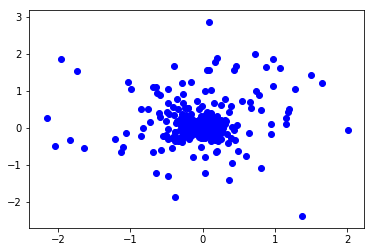

In [53]:
func_tools.iterative_drawing_2d(model, labels)

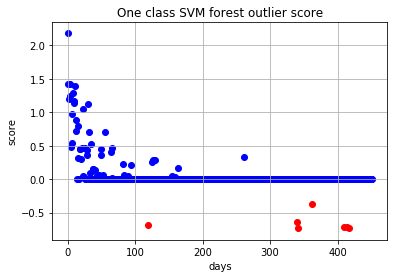

In [421]:
prev_cnt = 3
prev_dataset = []
for i, label in zip(range(prev_cnt+20, len(labels[prev_cnt:])), labels[prev_cnt:]):
    vector_weight = sum(np.exp(range(0, prev_cnt))) / np.exp(range(0, prev_cnt))
    prev_dataset.append(model.graph_embeddings[i] - sum(model.graph_embeddings[i-prev_cnt:i].T.dot(vector_weight)))

fig = plt.figure()
cls = OneClassSVM(kernel='rbf', gamma=5)
cls.fit(model.graph_embeddings[np.where(labels[prev_cnt:] == 0)[0]][:])
plt.scatter(np.where(labels[prev_cnt:]==0), 
            cls.decision_function(model.graph_embeddings)[np.where(labels[prev_cnt:]==0)], c='b', label='normal')
plt.scatter(np.where(labels[prev_cnt:]==1), 
            cls.decision_function(model.graph_embeddings)[np.where(labels[prev_cnt:]==1)], c='r', label='outlier')
plt.grid()
plt.title("One class SVM forest outlier score")
plt.ylabel('score')
plt.xlabel('days')
#fig.savefig('oneclass_svm.pdf', format='pdf')  

In [151]:
from sklearn.ensemble import RandomForestClassifier
cls = RandomForestClassifier(n_estimators = 100)
cls.fit(model.graph_embeddings, labels)

ValueError: Number of labels=636 does not match number of samples=637

# Simple SVM classification

In [144]:
labels = open('../DD/DD_label.txt')
labels = labels.read()
labels = np.array(map(lambda x: int(x), labels.strip().split()))

graph_embeddings = np.load('../experiments_data/DD/DD_doc_emb.npy')

outliers = graph_embeddings[np.random.choice(np.where(labels == 1)[0], 10)]
normal = graph_embeddings[np.where(labels == 0)[0]]

#outliers = graph_embeddings[np.where(labels == 1)[0]]
#normal = graph_embeddings[np.where(labels == 0)[0]]

In [155]:
labels[-100:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

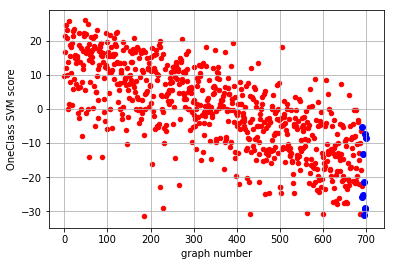

In [145]:
fig = plt.figure()
cls = OneClassSVM(kernel='rbf', gamma=1.9)
cls.fit(np.concatenate((normal, outliers), axis=0))
#cls.fit(normal[:])
plt.scatter(range(len(normal)), cls.decision_function(normal), c='r', s=20)
plt.scatter(range(len(normal), len(normal) + 10), cls.decision_function(outliers), c='b')
plt.ylabel('OneClass SVM score')
plt.xlabel('graph number')
plt.grid()
#fig.savefig('oneclass_svm_nci1_2.pdf', format='pdf')

In [121]:
cls = OneClassSVM(kernel='rbf', gamma=0.8)
cls.fit(np.concatenate((normal, outliers), axis=0))

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.8, kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [150]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV

cls = SVC()
X_train, X_test, y_train, y_test = train_test_split(graph_embeddings, 
                                                    labels, stratify=labels, test_size=0.01)

srch = RandomizedSearchCV(cls, {'gamma': np.linspace(0.01, 2, 40), 'kernel': ('linear', 'rbf')}, 
                          verbose=True, scoring='accuracy')

# srch = RandomizedSearchCV(cls, {'n_estimators': range(10, 200, 20), 'max_depth': range(3, 20, 2)}, 
#                          verbose=True, scoring='accuracy')

srch.fit(X_train, y_train)

#srch.fit(graph_embeddings, labels)
print "accuracy: ", accuracy_score(y_test, srch.best_estimator_.predict(X_test))
#print "prescicion: ", precision_score(y_test, srch.best_estimator_.predict(X_test))
#print "recall: ", recall_score(y_test, srch.best_estimator_.predict(X_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
accuracy:  0.75


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.1s finished


In [149]:
srch.best_score_

0.8842195540308748

In [151]:
srch.best_params_

{'gamma': 1.4897435897435898, 'kernel': 'rbf'}

In [91]:
srch.best_params_

{'gamma': 0.863448275862069, 'kernel': 'rbf'}

In [152]:
cls = SVC(kernel='rbf', gamma=1.5)
cv=KFold(n_splits=4, shuffle=True)
res = cross_val_score(cls, graph_embeddings, labels, scoring='accuracy', cv=cv)
print res

[0.87118644 0.87457627 0.89455782 0.88095238]


In [135]:
res.mean()

0.851063829787234

In [28]:
cls = SVC()
srch = RandomizedSearchCV(cls, {'gamma': np.linspace(0.001, 10, 100), 
                                'kernel': ('linear', 'rbf')}, verbose=True, scoring='roc_auc')
srch.fit(model.graph_embeddings, labels)
print "prescicion: ", precision_score(y_test, srch.best_estimator_.predict(X_test))
print "recall: ", recall_score(y_test, srch.best_estimator_.predict(X_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.5min finished


prescicion: 

NameError: name 'y_test' is not defined

In [ ]:
print "prescicion: ", precision_score(y_test, cls.predict(X_test))
print "recall: ", recall_score(y_test, cls.predict(X_test))

In [113]:
with model.graph.as_default():
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    v = sess.run(model.word_embeddings)    

193.41898


In [ ]:
recall_score